# Model Training
## Guide

In [1]:
guide_used = "https://www.kaggle.com/code/samuelcortinhas/gaussian-mixture-model-gmm-from-the-ground-up"

## Make necessary imports

In [94]:
import opendatasets as od
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import scipy.stats
import sklearn.decomposition
import plotly.express as px
from matplotlib import cm

## Define Model Class

In [26]:
class GMM:
    def __init__(self, k, max_iter=100, random_state = 0):
        self.k = k
        self.max_iter = max_iter
        self.random_state = random_state

    def initialise(self, X):
        self.shape = X.shape
        self.n, self.d = self.shape
        
        self.pi = np.full(shape=self.k, fill_value=1/self.k)
        self.responsibilities = np.full(shape=self.shape, fill_value=1/self.k)
        
        np.random.seed(self.random_state)
        random_row = np.random.randint(low=0, high=self.n, size=self.k)
        self.mu = [X[row_index,:] for row_index in random_row]
        self.sigma = [np.cov(X.T) for _ in range(self.k)]

    def E_step(self, X):
        # E-Step: update the responsibilities by holding mu and sigma constant
        self.responsibilities = self.predict_proba(X)
    
    def M_step(self, X):
        # M-Step: update pi, mu and sigma by holding responsibilities constant
        self.pi = self.responsibilities.mean(axis=0)
        for j in range(self.k):
            r_column = self.responsibilities[:,j]
            total_responsibility = r_column.sum()
            self.mu[j] = (X * r_column[:, np.newaxis]).sum(axis=0)/total_responsibility
            self.sigma[j] = np.cov(X.T, aweights=(r_column/total_responsibility).flatten(), bias=True)

    def fit(self, X):
        self.initialise(X)
        
        for iteration in range(self.max_iter):
            self.E_step(X)
            self.M_step(X)
    
    def predict_proba(self, X):
        likelihood = np.zeros((self.n, self.k))
        for j in range(self.k):
            distribution = scipy.stats.multivariate_normal(mean=self.mu[j], cov=self.sigma[j])
            likelihood[:,j] = distribution.pdf(X)
        
        numerator = likelihood * self.pi
        denominator = numerator.sum(axis=1)[:, np.newaxis]
        responsibilities = numerator / denominator
        return responsibilities
    
    def predict(self, X):
        responsibilities = self.predict_proba(X)
        return np.argmax(responsibilities, axis=1)
    
    def fit_predict(self, X):
        self.fit(X)
        predictions = self.predict(X)
        return predictions

## Importing data

Import data:

In [5]:
od.download("https://www.kaggle.com/datasets/arshid/iris-flower-dataset")   # Got error, so I downloaded it manually

Skipping, found downloaded files in ".\iris-flower-dataset" (use force=True to force download)


Read data:

In [11]:
file = 'iris-flower-dataset/IRIS.csv'
iris = pd.read_csv(file)
iris.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


Preprocess data:

In [32]:
X = iris.iloc[:, [0, 1, 2, 3]].values

## Visualization

Scatter plot:

Text(0.5, 1.0, '2 dimensional data with 3 clusters')

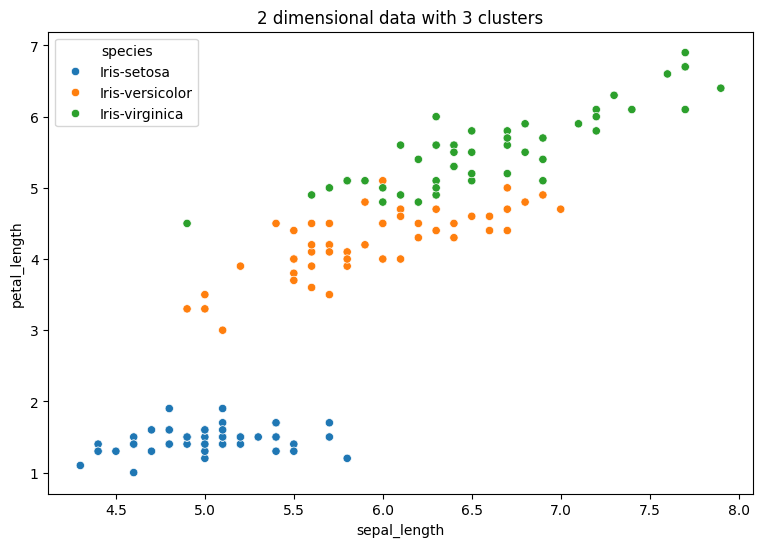

In [91]:
# Scatterplot
fig = plt.figure(figsize=(20,6))
fig.add_subplot(121)
ax1 = sns.scatterplot(data=iris, x='sepal_length', y='petal_length', hue='species')
ax1.set_title('2 dimensional data with 3 clusters')

3D plot with gaussian mixture estimate:

In [137]:
# DOES NOT WORK

'''3D plot for 2D gaussian mixture estimation'''
# Define grid
x = np.linspace(4,9, num=100)
y = np.linspace(0,8, num=100)
x, y = np.meshgrid(x, y)
z = 0

# Estimate gaussian parameters
for flower in ['Iris-setosa','Iris-versicolor','Iris-virginica']:
    mu = iris[iris['species']==flower].iloc[:,:-1].mean()
    sigma = np.diag(iris[iris['species']==flower].iloc[:,:-1].cov())
    z += scipy.stats.multivariate_normal.pdf(x=x, mean=mu, cov=sigma)
    print(z)

# Plot 3D plot with gaussian mixture estimate
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(x,y,z, cmap=cm.jet)
ax2.set_title('2D Gaussian mixture plotted in 3D')
ax2.set_xlabel('sepal_length')
ax2.set_ylabel('petal_length')
plt.show()

ValueError: operands could not be broadcast together with shapes (100,100) (4,) 

## Gaussian Mixture Model

In [33]:
# Gaussian Mixture Model
gmm = GMM(k=7, max_iter=100)
preds = gmm.fit_predict(X)

### Visualizations

Count plot:

Text(0.5, 1.0, 'Predicted clusters')

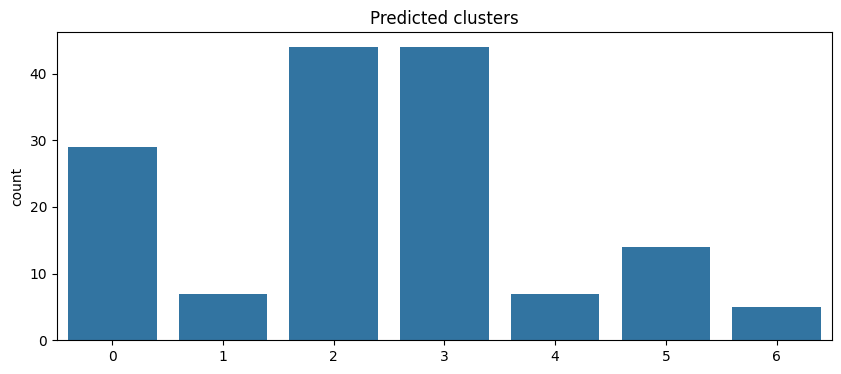

In [35]:
# Countplot
plt.figure(figsize=(10,4))
sns.countplot(x=preds)
plt.title('Predicted clusters')

Cluster distributions (Histograms of features):

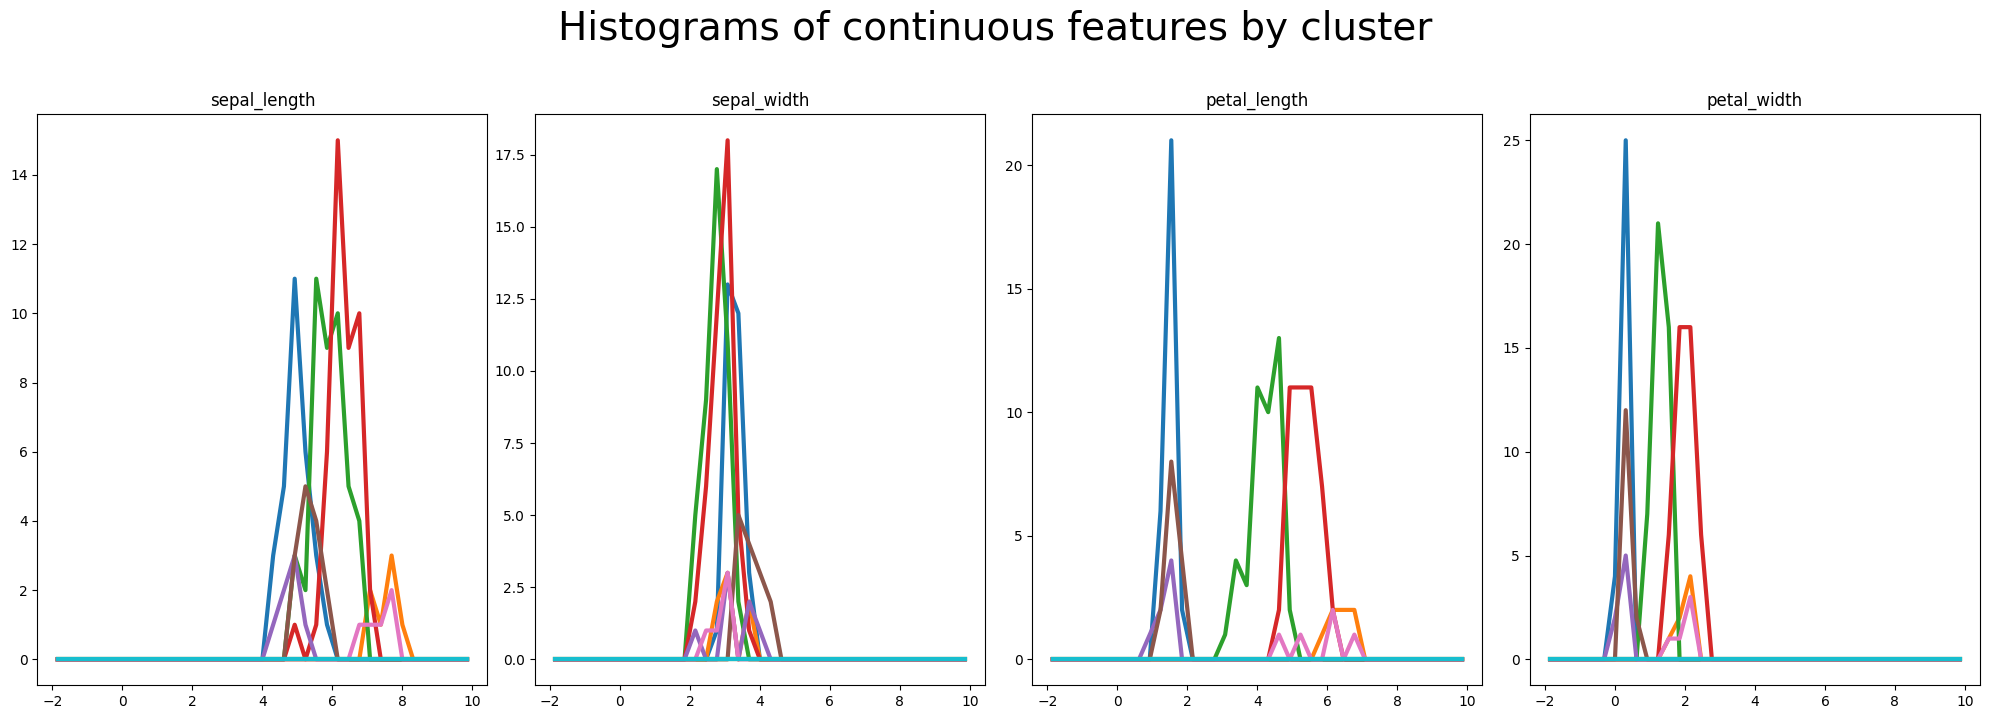

In [79]:
# From https://www.kaggle.com/code/ambrosm/tpsjul22-gaussian-mixture-cluster-analysis
fig, axs = plt.subplots(1, 4, figsize=(20, 7))
axs = axs.ravel()
feature_columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
feature_columns_idx = range(4)
y=preds
for ax, feature, idx in zip(axs, feature_columns, feature_columns_idx):
    for i in range(10):
        h, edges = np.histogram(X[y == i, idx], bins=np.linspace(-2, 10, 40))
        ax.plot((edges[:-1] + edges[1:]) / 2, h, label=f"Cluster {i}", lw=3)
    ax.set_title(feature)
plt.suptitle('Histograms of continuous features by cluster', y=1.02, fontsize=28)
fig.tight_layout(h_pad=1.0, w_pad=0.5)
plt.show()

## PCA

In [81]:
# PCA
pca = sklearn.decomposition.PCA(n_components=3)
components = pca.fit_transform(X)

Scatter plot:

In [88]:
# 3D scatterplot
fig = px.scatter_3d(
    components, x=0, y=1, z=2, color=preds, size=0.1*np.ones(len(X)), opacity = 1,
    title='PCA plot in 3D',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'},
    width=650, height=500
)
fig.show()